In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.utils import to_categorical

2025-04-27 16:19:10.361694: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 16:19:10.362066: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 16:19:10.364233: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 16:19:10.370189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745788750.381203    2751 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745788750.38

# Task: Build a CNN-LSTM hybrid model to classify the customer product reviews into good or bad.

## Task A
### Load GrammarandProductReviews.csv dataset

In [2]:
df = pd.read_csv('GrammarandProductReviews.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10001 non-null  object 
 1   brand                 10001 non-null  object 
 2   categories            10001 non-null  object 
 3   dateAdded             10001 non-null  object 
 4   dateUpdated           10001 non-null  object 
 5   ean                   6866 non-null   object 
 6   keys                  10001 non-null  object 
 7   manufacturer          10001 non-null  object 
 8   manufacturerNumber    9983 non-null   object 
 9   name                  10001 non-null  object 
 10  reviews.date          9987 non-null   object 
 11  reviews.dateAdded     10001 non-null  object 
 12  reviews.dateSeen      10001 non-null  object 
 13  reviews.didPurchase   3637 non-null   object 
 14  reviews.doRecommend   9442 non-null   object 
 15  reviews.id         

In [4]:
df.head(5)

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.03E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.03E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427


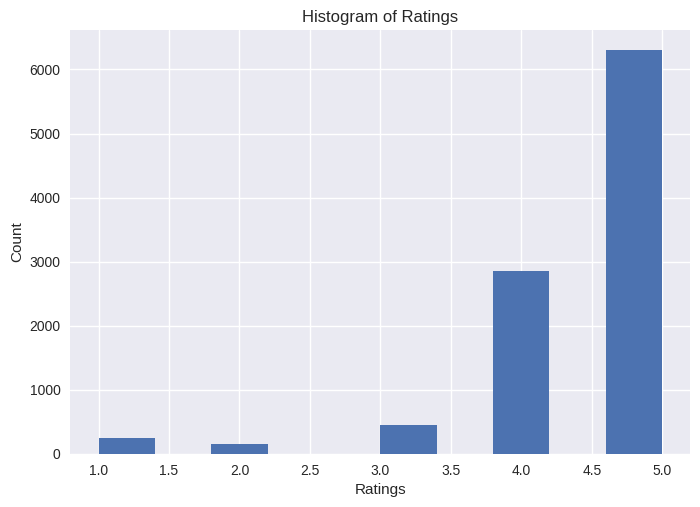

In [5]:
plt.style.use('seaborn-v0_8')
plt.hist(df['reviews.rating'])
plt.title('Histogram of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

### Create a feature named target by considering that if a customer is pleased by the product, the rating is higher than 3. Any rating below 4 shows that the customer doesn’t like the product. Use column reviews.rating to create feature target (Hint: df['target'] = df['reviews.rating'] < 4 )

In [6]:
df['liked_product'] = (df['reviews.rating']>3).astype(int) # Filter who liked

In [7]:
df['disliked_product'] = (df['reviews.rating']<4).astype(int) #filter who disliked

### Create your X with column reviews.text and Y with column target.

In [8]:
X = df['reviews.text']
y = df['disliked_product']

### Split your dataset into train and test in the ratio 80:20

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)

In [10]:
print(X_train.shape)
print(X_test.shape)

(8000,)
(2001,)


In [11]:
X_train.head()

7194    Clorox wipes are easy to use, therefore more l...
3499                          Great cereal. Kids love it.
6394                                Ok for chili in a can
5652    Season 1 is easily the best of the 3 seasons s...
6314    Great movie, fun, lots of good actors in the c...
Name: reviews.text, dtype: object

In [12]:
X_train.isnull().sum()

np.int64(2)

In [13]:
X_test.isnull().sum()

np.int64(0)

In [14]:
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

### Use a tokenizer from Keras to vectorize the text samples into a 2D integer tensor with 20000 words. Fit your tokenizer on train data (MAX_NB_WORDS = 20000)

Note: You may use different tokenizers (from scikit-learn, NLTK, custom Python function etc.) This converts text into sequences of indices representing the 20000 most frequent words.

In [15]:
max_nb_words = 20000
tokenizer = Tokenizer(num_words=max_nb_words)
tokenizer.fit_on_texts(X_train)

### Convert train texts to sequences using the tokenizer texts_to_sequences method

In [16]:
train_sequences = tokenizer.texts_to_sequences(X_train)

### Convert test texts to sequences using tokenizer texts_to_sequences method

In [17]:
test_sequences = tokenizer.texts_to_sequences(X_test)

### Pad train and test sequence (add 0s at the end until the sequence is of length 150). Consider MAX_SEQUENCE_LENGTH = 150 and this step gives x_train and x_test

In [18]:
max_sequence_length = 150
train_pad = pad_sequences(train_sequences, maxlen=max_sequence_length)
test_pad = pad_sequences(test_sequences, maxlen=max_sequence_length)

### One-hot encode your output classes (True/False)

In [19]:
y_train = to_categorical(y_train)  # Converts to a 2D array for softmax output
y_test = to_categorical(y_test)

### Build a CNN - LSTM hybrid model with the following layers:
•Input layer with input shape = MAX_SEQUENCE_LENGTH and dtype int32

•Embedding layer with input dimension = MAX_NB_WORDS, output dimension =50, and input length = MAX_SEQUENCE_LENGTH 

•Conv1D layer with 64 filters and kernel size 5 and activation relu, followed by MaxPooling1D with pool size = 5 

Hint: MaxPool divides the length of the sequence by:

•Dropout(0.2)

•Conv1D layer with 64 filters and kernel size 5 and activation relu, followed by MaxPooling1D with pool size = 5

•Dropout(0.2)

•LSTM layer with 64 units

•Dense layer with 2 neurons and activation softmax


In [20]:
Embedding_dim = 50
model = models.Sequential([
    Embedding(input_dim=max_nb_words, output_dim=Embedding_dim, input_length=max_sequence_length),
    layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    layers.MaxPool1D(pool_size=5),
    layers.Dropout(0.2),
    layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    layers.MaxPool1D(pool_size=5),
    layers.Dropout(0.2),
    LSTM(units=64),
    layers.Dense(2, activation='softmax')
])

/home/cullen-fedora/Documents/Python-Projects/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-04-27 16:19:13.230679: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Compile the model with Adam optimizer and metric accuracy

In [21]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

### Train the model for 5 epochs and batch size 64

In [22]:
history = model.fit(
    train_pad,
    y_train,
    validation_split=0.1,
    epochs = 5,
    batch_size= 64
)

Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9076 - loss: 0.3630 - val_accuracy: 0.9212 - val_loss: 0.2792
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9155 - loss: 0.2868 - val_accuracy: 0.9212 - val_loss: 0.2803
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9133 - loss: 0.2794 - val_accuracy: 0.9212 - val_loss: 0.3110
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9223 - loss: 0.2383 - val_accuracy: 0.9112 - val_loss: 0.3259
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9426 - loss: 0.1750 - val_accuracy: 0.9062 - val_loss: 0.3608


### Evaluate the model on test text  and print the test loss and accuracy

In [23]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

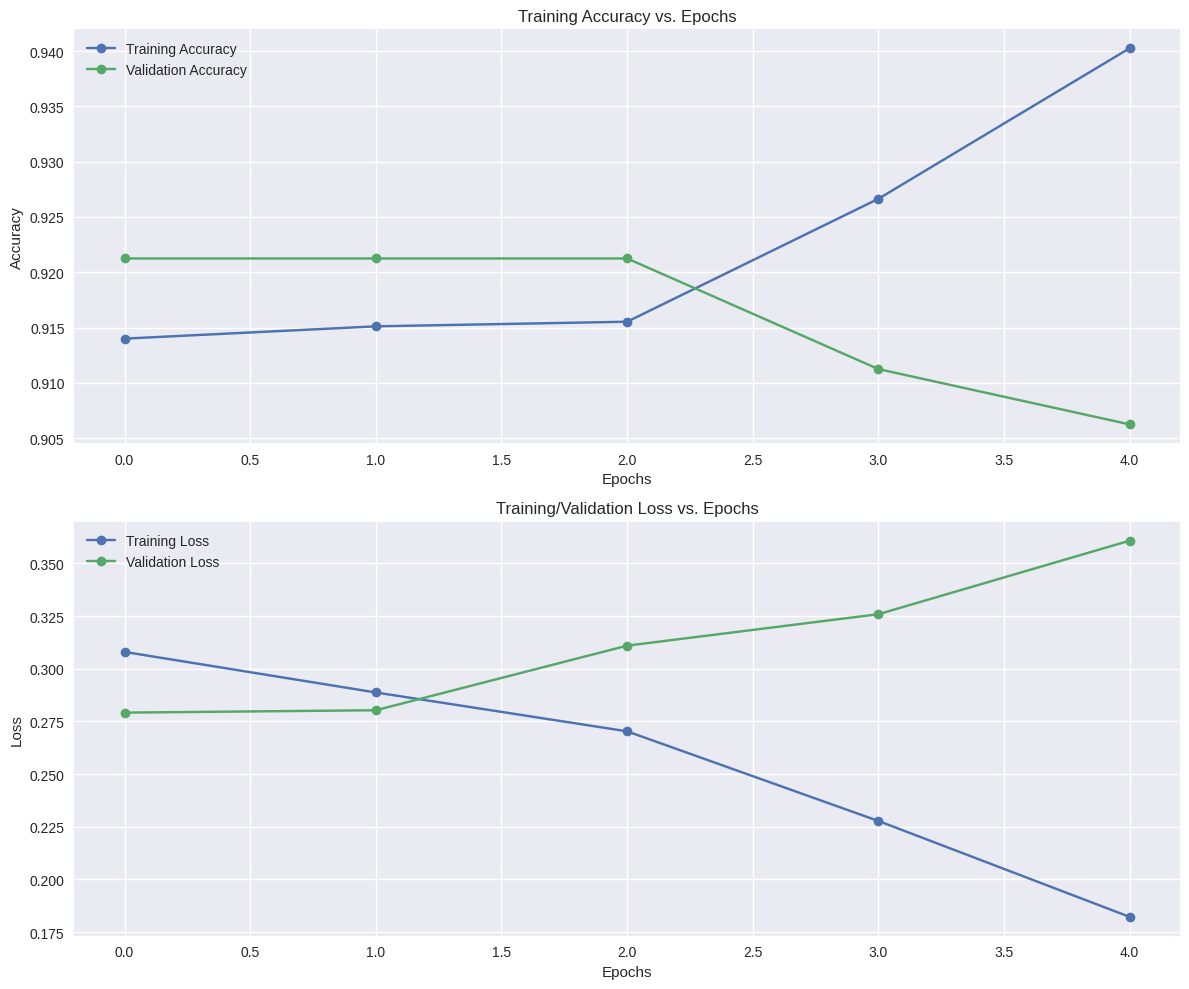

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Training Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Training Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

#### Observations
- Training accuracy increases and training loss decrease steadily.
- Model begins to overfit as validation accuracy dips below training accuracy and validation loss gets higher than training loss

## Task B

### As a future and take-home task, train the model with the full dataset available in this link - 
Grammar and Online Product Reviews | Kaggle.

In [25]:
full_df = pd.read_csv('full_GrammarandProductReviews.csv')

In [26]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71044 entries, 0 to 71043
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    71044 non-null  object 
 1   brand                 71044 non-null  object 
 2   categories            71044 non-null  object 
 3   dateAdded             71044 non-null  object 
 4   dateUpdated           71044 non-null  object 
 5   ean                   39065 non-null  object 
 6   keys                  71044 non-null  object 
 7   manufacturer          70903 non-null  object 
 8   manufacturerNumber    70841 non-null  object 
 9   name                  71044 non-null  object 
 10  reviews.date          70977 non-null  object 
 11  reviews.dateAdded     71044 non-null  object 
 12  reviews.dateSeen      71044 non-null  object 
 13  reviews.didPurchase   32158 non-null  object 
 14  reviews.doRecommend   60429 non-null  object 
 15  reviews.id         

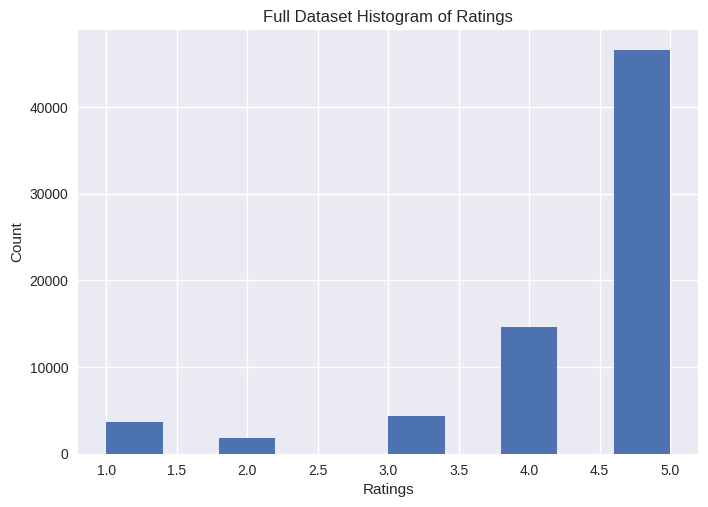

In [27]:
plt.style.use('seaborn-v0_8')
plt.hist(full_df['reviews.rating'])
plt.title('Full Dataset Histogram of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [28]:
full_df['disliked_product'] = (full_df['reviews.rating']<4).astype(int)
full_X_train, full_X_test, full_y_train, full_y_test = train_test_split(X,y, train_size=0.8)

In [29]:
full_X_train.dropna(inplace=True)
full_X_test.dropna(inplace=True)

In [30]:
max_nb_words = 20000
tokenizer = Tokenizer(num_words=max_nb_words)
tokenizer.fit_on_texts(full_X_train)
train_sequences = tokenizer.texts_to_sequences(full_X_train)
test_sequences = tokenizer.texts_to_sequences(full_X_test)
max_sequence_length = 150
full_train_pad = pad_sequences(train_sequences, maxlen=max_sequence_length)
full_test_pad = pad_sequences(test_sequences, maxlen=max_sequence_length)
full_y_train = to_categorical(full_y_train)  # Converts to a 2D array for softmax output
full_y_test = to_categorical(full_y_test)

In [31]:
full_history = model.fit(
    full_train_pad,
    full_y_train,
    validation_split=0.1,
    epochs = 5,
    batch_size= 64
)

Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9104 - loss: 0.3187 - val_accuracy: 0.9325 - val_loss: 0.2554
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9107 - loss: 0.2696 - val_accuracy: 0.9237 - val_loss: 0.2738
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9343 - loss: 0.2018 - val_accuracy: 0.9087 - val_loss: 0.3092
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9521 - loss: 0.1608 - val_accuracy: 0.8988 - val_loss: 0.3418
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9673 - loss: 0.1155 - val_accuracy: 0.9075 - val_loss: 0.3497


### Evaluate the model on full test data and compare the performance improvement from a subset of the full dataset

In [32]:
full_train_accuracy = history.history['accuracy']
full_val_accuracy = history.history['val_accuracy']

full_train_loss = history.history['loss']
full_val_loss = history.history['val_loss']

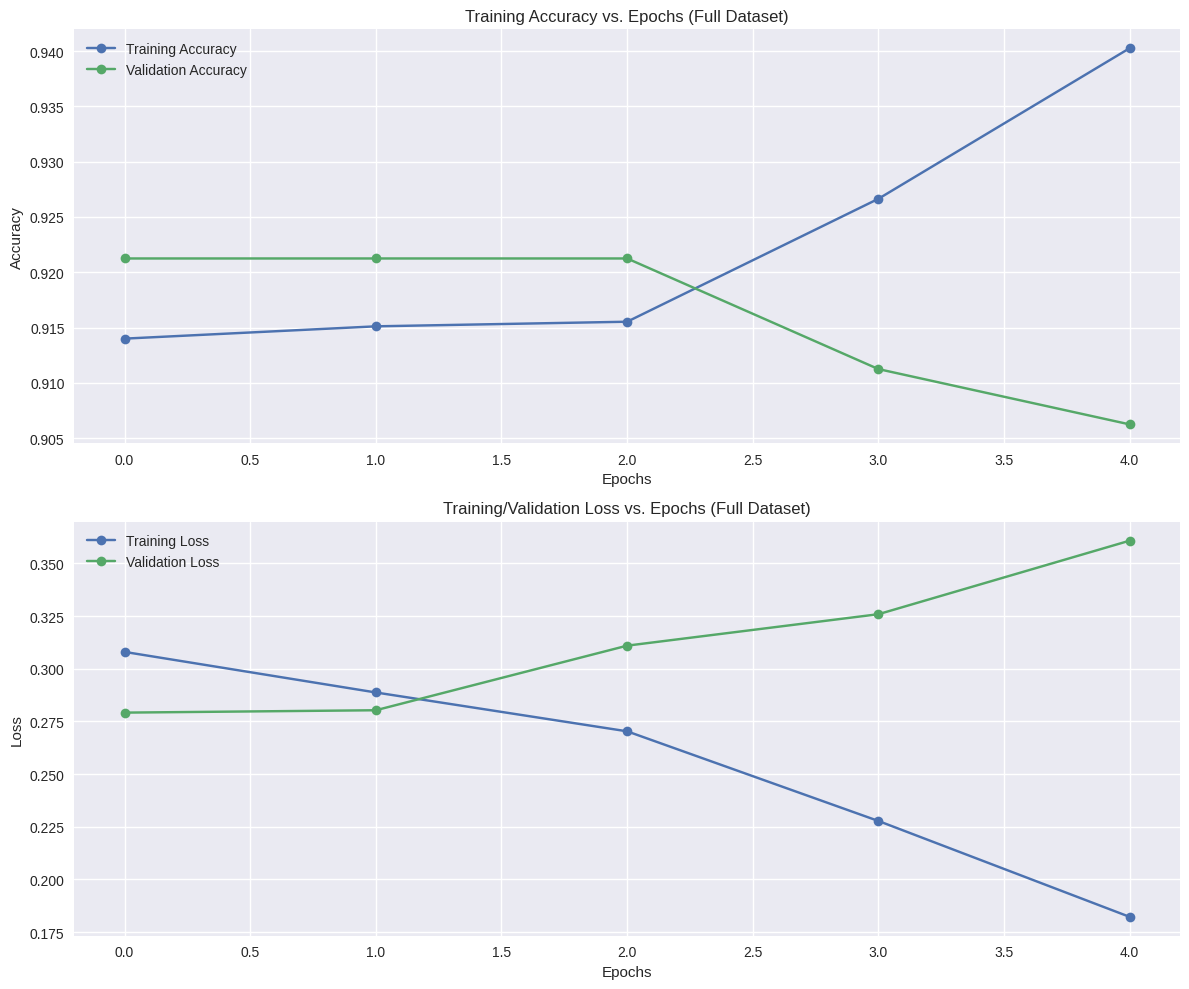

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs (Full Dataset)')
ax[0].plot(full_train_accuracy, 'o-', label='Training Accuracy')
ax[0].plot(full_val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs (Full Dataset)')
ax[1].plot(full_train_loss, 'o-', label='Training Loss')
ax[1].plot(full_val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

#### Observations
- With the full dataset, it appears to overfit much fasters, following the same trend with the partial dataset.
- Model would benefit from techniques to improve generalization, like increasing the dropout layer, adding L2 regularizers, adjusting learning rate, or adjusting early stopping